Introduction

Heart disease is increasingly common and one of the leading causes of death around the world. As algorithms and modeling become more accessible and sophisticated, they can be used to predict and diagnose heart disease. Here, we will create a simple model using the k-nearest neighbors algorithm to predict the type of chest pain in individuals testing for heart disease. We will investigate how accurately we can predict the type of chest pain with a K-nearest Neighbour model?

The dataset we will use is called “processed.cleveland.data” from the Machine Learning Repository. Data was collected between May 1981 and September 1984 and stems from the angiography results of 303 patients at the Cleveland Clinic in Cleveland, Ohio. Similar algorithms have been created like the one described in Detrano et al.’s International Application of a New Probability Algorithm for the Diagnosis of Coronary Artery Disease where the same data set, along with similar ones, trained an algorithm to predict heart disease.

Methods and Variable Selection

As mentioned previously, we will develop a model using this dataset to predict the type of chest pain that an individual is experiencing. The potential types of chest pain are typical angina, atypical angina, non-anginal pain, and asymptomatic pain. Our model will use the k-nearest neighbours algorithm and consider age, sex, electrocardiogram rate at rest (restecg), systolic blood pressure (trestbps), and cholesterol (chol) as variables. Age and sex were chosen because women with CHD tend to be older than men with CHD, and test of CHD increases with age in both sexes. By incorporating age and sex, we can better estimate an individual’s likelihood of developing CHD. The electrocardiogram at rest provides information about heart rate, rhythm and potential heart enlargement, making it a useful tool for investigating symptoms. A higher risk of heart disease associated with elevated systolic blood pressure, which damages arteries and impedes blood flow to the heart muscle. Additionally, a high level of serum cholesterol in the blood increases the risk of heart disease by promoting the development of fatty deposits in blood vessels, which can hinder flow through arteries.

We can visualise the results using a bar chart to show the frequency of the times we accurately predicted the chest pain type for the testing data and the time we failed.



In [1]:
library(tidyverse)
library(tidymodels)
set.seed(777)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We need to first read the dataset from the internet. After reading the data, we can rename the columns to make the data more informative. This is done below:

In [2]:

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cleveland_data <- read_csv(url, col_names = FALSE)
cleveland_data <- rename(cleveland_data,
       age = X1, 
       sex = X2, 
       cp = X3,
       trestbps = X4, 
       chol = X5, 
       fbs = X6, 
       restecg = X7, 
       thalach = X8, 
       exang = X9, 
       oldpeak = X10, 
       slope = X11, 
       ca = X12, 
       thal = X13, 
       num = X14)


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The data is then mutated to convert the columns into the right variable type. For example, since cp(chest pain) is a factor, we can use the as_factor function to convert the column.

In [3]:
 cd_mutate <- cleveland_data |>
mutate(sex = as_factor(sex)) |> 
mutate(cp = as_factor(cp)) |> 
mutate(fbs = as_factor(fbs)) |> 
mutate(restecg = as_factor(restecg)) |> 
mutate(exang = as_factor(exang)) |> 
mutate(slope = as_factor(slope)) |> 
mutate(ca = as_factor(ca)) |>
mutate(thal = as_factor(thal)) |> 
mutate(num = as_factor(num))


The dataset for heart disease contains "?" instead of NA values which might be difficult to deal with later on. We can replace all the "?" to NA as shown below.

In [4]:
cd_mutate[cd_mutate == "?"] <- NA
cd_mutate

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2


For this model, we will be using the variables age, sex, chol, restecg, trestbps to predict the cp type. Hence, we should select these columns from the dataset. 

In [5]:
cd_select<-select(cd_mutate, age, sex, chol, restecg,  trestbps, cp)

We have cleaned and wrangled the data to give a tidy data frame. We can now proceed to split the data into training and testing sets to conduct exploratory data analysis.

In [6]:

cd_split<-initial_split(cd_select, prop=0.75, strata=cp)
cd_training<-training(cd_split)
cd_test<-testing(cd_split)


We can now calculate the mean for the variables that are not a factor, namely age, trestbps, and chol. The following means are depicted in the table as shown below.

In [7]:
cd_means<-cd_training|>
    summarize(mean_age = mean(age),
            mean_trestbps = mean(trestbps),
              mean_chol = mean(chol))
cd_means            

mean_age,mean_trestbps,mean_chol
<dbl>,<dbl>,<dbl>
54.50885,132.031,248.2345


As seen from the table, the average age of 54.5 is quite high. With age, the heart condition deteriorates and may lead to complications. This indicates that the dataset should have high variability.

For the remaining columns which are factors, we can use a plot to visualize the frequencies for each occurence. First, we use the table() function to get a table with the correct counts and then use the as.data.frame function to convert it into a data frame.

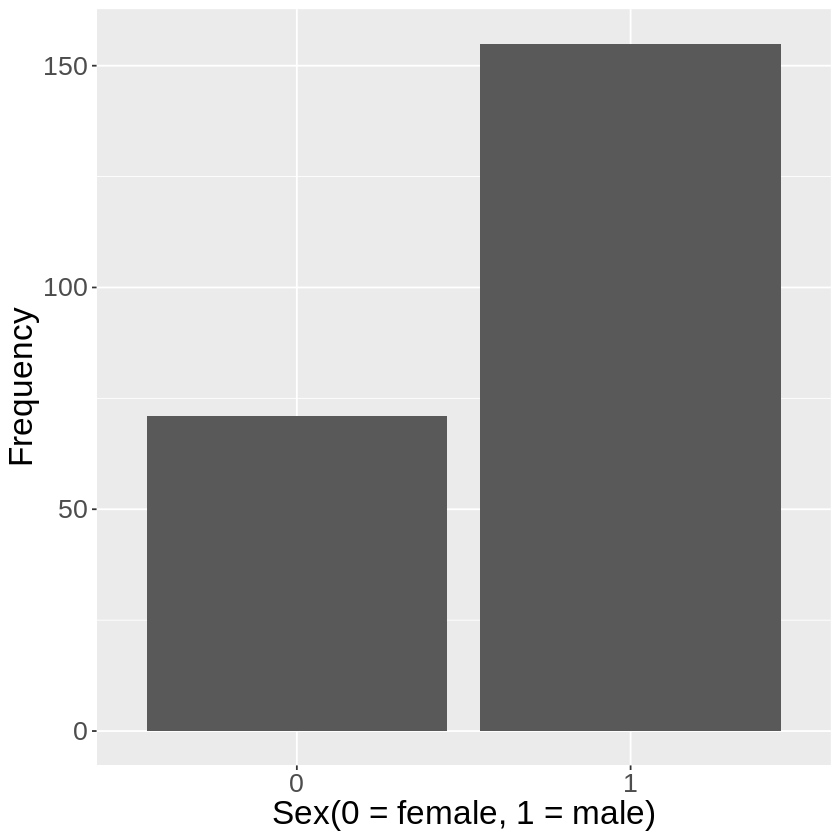

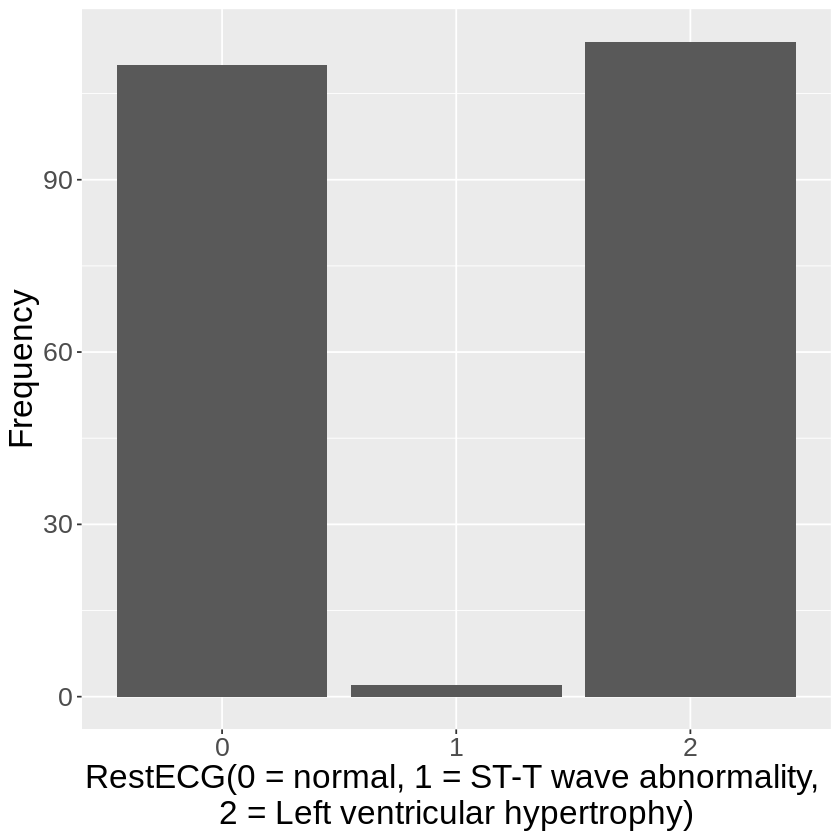

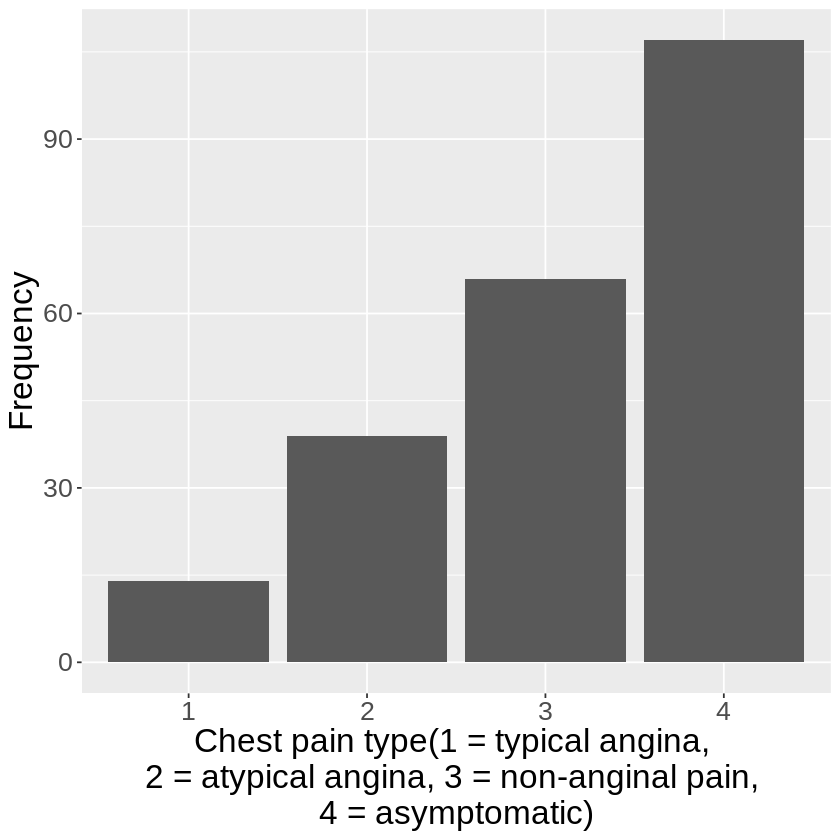

In [8]:
cd_training_sex <- as.data.frame(table(cd_training$sex))
cd_training_restecg <- as.data.frame(table(cd_training$restecg)) 
cd_training_cp <- as.data.frame(table(cd_training$cp))

cd_training_plot_sex <- ggplot(cd_training_sex, aes(x = Var1, y = Freq))+
                        geom_bar(stat = "identity") +
                        labs(x = "Sex(0 = female, 1 = male)", y = "Frequency") +
                        theme(text = element_text(size = 20))
cd_training_plot_restecg <- ggplot(cd_training_restecg, aes(x = Var1, y = Freq))+
                        geom_bar(stat = "identity") +
                        labs(x = "RestECG(0 = normal, 1 = ST-T wave abnormality, 
2 = Left ventricular hypertrophy)", y = "Frequency") +
                        theme(text = element_text(size = 20))
cd_training_plot_cp <- ggplot(cd_training_cp, aes(x = Var1, y = Freq))+
                        geom_bar(stat = "identity") +
                        labs(x = "Chest pain type(1 = typical angina, 
2 = atypical angina, 3 = non-anginal pain, 
4 = asymptomatic)", y = "Frequency") +
                        theme(text = element_text(size = 20))
cd_training_plot_sex
cd_training_plot_restecg
cd_training_plot_cp


As seen from the graphs, a couple of things stand out. The data contains a lot of values for males compared to females, and an ST-T Wave abnormality is very rare for a restecg. Additionally, majority of the data values are asymptomatic which could make classifying the chest pain type less accurate.

Expected Outcomes and Significance

We hope to develop a model that can predict the chest pain type. Determining the types of chest pain is important because chest pain is often caused by poor blood flow to the heart, which could indicate heart disease and dangers to a life. Different types of chest pain have different potential underlying diagnoses. Follow up questions may include how does chest pain type correlate to testing postive for heart disease? Or even, how do different chest pains indicate the future development of heart conditions?

References

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J.-J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American Journal of Cardiology, 64(5), 304–310. https://doi.org/10.1016/0002-9149(89)90524-9